In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.regression import linear_model

In [3]:
diab_df = pd.read_csv('diabetes.csv')
diab_df.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,prog
0,59,1,32.1,101.0,157,93.2,38.0,4.0,2.11,87,151
1,48,0,21.6,87.0,183,103.2,70.0,3.0,1.69,69,75
2,72,1,30.5,93.0,156,93.6,41.0,4.0,2.03,85,141
3,24,0,25.3,84.0,198,131.4,40.0,5.0,2.12,89,206
4,50,0,23.0,101.0,192,125.4,52.0,4.0,1.86,80,135


In [4]:
# As usual, center
for col in diab_df.columns:
    if col != 'prog':
        diab_df[col] = (diab_df[col] - diab_df[col].mean())
    else:
        diab_df[col] = diab_df[col] - diab_df[col].mean()
diab_df.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,prog
0,10.4819,0.531674,5.724208,6.353394,-32.140271,-22.23914,-11.788462,-0.070249,0.094253,-4.260181,-1.133484
1,-0.5181,-0.468326,-4.775792,-7.646606,-6.140271,-12.23914,20.211538,-1.070249,-0.325747,-22.260181,-77.133484
2,23.4819,0.531674,4.124208,-1.646606,-33.140271,-21.83914,-8.788462,-0.070249,0.014253,-6.260181,-11.133484
3,-24.5181,-0.468326,-1.075792,-10.646606,8.859729,15.96086,-9.788462,0.929751,0.104253,-2.260181,53.866516
4,1.4819,-0.468326,-3.375792,6.353394,2.859729,9.96086,2.211538,-0.070249,-0.155747,-11.260181,-17.133484


In [5]:
# Compute S matrix to get normalization constants
S_mat = np.matmul(np.array(diab_df.drop('prog',1)).T, np.array(diab_df.drop('prog',1)))

In [6]:
# Normalize such that sum of squares of each column is equal to 1.
for col in range(S_mat.shape[0]):
    diab_df.iloc[:,col] = diab_df.iloc[:,col] / np.sqrt(S_mat[col][col])

In [8]:
diab_df.head()

,age,sex,bmi,map,tc,ldl,hdl,tch,ltg,glu,prog
0,0.038076,0.050680,0.061696,0.021873,-0.044223,-0.034821,-0.043401,-0.002592,0.019768,-0.017646,-1.133484
1,-0.001882,-0.044642,-0.051474,-0.026325,-0.008449,-0.019163,0.074412,-0.039493,-0.068320,-0.092204,-77.133484
2,0.085299,0.050680,0.044451,-0.005669,-0.045599,-0.034194,-0.032356,-0.002592,0.002989,-0.025930,-11.133484
3,-0.089063,-0.044642,-0.011595,-0.036653,0.012191,0.024991,-0.036038,0.034309,0.021865,-0.009362,53.866516
4,0.005383,-0.044642,-0.036385,0.021873,0.003935,0.015596,0.008142,-0.002592,-0.032665,-0.046641,-17.133484


In [9]:
# Use Ridge regression estimator
S_mat = np.matmul(np.array(diab_df.drop('prog',1)).T, np.array(diab_df.drop('prog',1)))
y = diab_df['prog'].values
identity_dim = np.identity(diab_df.shape[1] - 1) # of x variables
lam_grid = np.linspace(0,0.25,26)

# Collector dataframe

estimates_df = pd.DataFrame({'variable':[], 'beta_values':[], 'lambda':[], 'std_errs':[]})
estimates_work = pd.DataFrame({'variable':[], 'beta_values':[], 'lambda':[], 'std_errs':[]})

# Loop for lambda values
for lambda_ridge in lam_grid:
    S_ridge_inv = np.linalg.inv(S_mat + lambda_ridge * identity_dim)
    beta_ridge = np.matmul(np.matmul(S_ridge_inv, np.array(diab_df.drop('prog',1)).T), y) 
    estimates_work['variable'] = diab_df.drop('prog',1).columns
    estimates_work['beta_values'] = beta_ridge
    estimates_work['lambda'] = lambda_ridge
    y_hats = diab_df.drop('prog', 1).apply(lambda row: np.dot(row.values, 
                                   estimates_work['beta_values']), 1)
    residuals = diab_df['prog'] - y_hats
    sig_sq = np.var(residuals)
    beta_stds = np.sqrt(sig_sq * np.diag(np.matmul(np.matmul(S_ridge_inv, S_mat), S_ridge_inv)))
    estimates_work['std_errs'] = beta_stds
    
    estimates_df = pd.concat([estimates_df, estimates_work], sort=False)

In [14]:
# Table 7.3
summ_table = pd.DataFrame()
summ_table['beta_hat_lam0'] = np.round(estimates_df.loc[estimates_df['lambda']==0, 'beta_values'],1)
summ_table['beta_hat_lam0.1'] = np.round(estimates_df.loc[estimates_df['lambda']==0.1, 'beta_values'],1)
summ_table['sd_lam0'] = np.round(estimates_df.loc[estimates_df['lambda']==0, 'std_errs'],1)
summ_table['sd_lam0.1'] = np.round(estimates_df.loc[estimates_df['lambda']==0.1, 'std_errs'],1)
summ_table

,beta_hat_lam0,beta_hat_lam0.1,sd_lam0,sd_lam0.1
0,-9.7,1.5,59.0,52.4
1,-239.1,-206.8,60.5,52.9
2,519.2,489.3,65.7,56.0
3,324.1,301.6,64.6,55.4
4,-787.0,-83.2,411.2,43.4
5,472.1,-71.2,334.5,52.1
6,99.9,-188.3,209.9,58.1
7,177.2,115.8,159.5,70.3
8,749.4,443.8,169.7,58.0
9,68.0,86.9,65.2,56.2


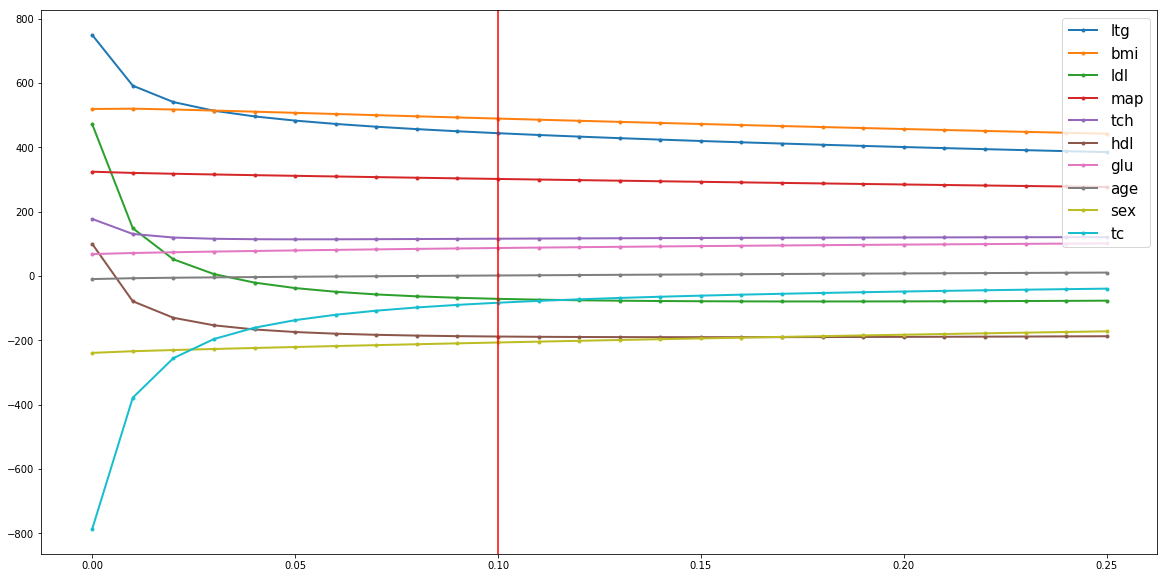

In [15]:
# Ridge Trace Plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)
with plt.style.context('Solarize_Light2'):
    ax.plot(estimates_df['lambda'].unique(), estimates_df.loc[estimates_df['variable']=='ltg', 'beta_values'], '.-')
    ax.plot(estimates_df['lambda'].unique(), estimates_df.loc[estimates_df['variable']=='bmi', 'beta_values'], '.-')
    ax.plot(estimates_df['lambda'].unique(), estimates_df.loc[estimates_df['variable']=='ldl', 'beta_values'], '.-')
    ax.plot(estimates_df['lambda'].unique(), estimates_df.loc[estimates_df['variable']=='map', 'beta_values'], '.-')
    ax.plot(estimates_df['lambda'].unique(), estimates_df.loc[estimates_df['variable']=='tch', 'beta_values'], '.-')
    ax.plot(estimates_df['lambda'].unique(), estimates_df.loc[estimates_df['variable']=='hdl', 'beta_values'], '.-')
    ax.plot(estimates_df['lambda'].unique(), estimates_df.loc[estimates_df['variable']=='glu', 'beta_values'], '.-')
    ax.plot(estimates_df['lambda'].unique(), estimates_df.loc[estimates_df['variable']=='age', 'beta_values'], '.-')
    ax.plot(estimates_df['lambda'].unique(), estimates_df.loc[estimates_df['variable']=='sex', 'beta_values'], '.-')
    ax.plot(estimates_df['lambda'].unique(), estimates_df.loc[estimates_df['variable']=='tc', 'beta_values'], '.-')

ax.axvline(0.1, c='r')
ax.legend(['ltg', 'bmi', 'ldl', 'map', 'tch', 'hdl', 'glu', 'age', 'sex', 'tc'],loc=1, prop={'size': 15})